# Transverse field Ising model to demo primitives

In [17]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import YGate, UnitaryGate
import numpy as np 


SYGate = UnitaryGate(YGate().power(1/2), label=r"$\sqrt{Y}$")
SYdgGate = UnitaryGate(SYGate.inverse(), label=r"$\sqrt{Y}^\dag$")

def generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, num_cl_bits=0, trotter_barriers=False, layer_barriers=False):
    if num_cl_bits == 0:
        qc = QuantumCircuit(num_qubits)
    else:
        qc = QuantumCircuit(num_qubits, num_cl_bits)

    for trotter_step in range(num_trotter_steps):
        add_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers)
        if trotter_barriers:
            qc.barrier()

    return qc

def add_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers=False):
    #adding Rzz gates in even layers 
    for i in range(0, qc.num_qubits - 1, 2):
        qc.sdg([i, i+1])
        qc.append(SYGate, [i+1])
        qc.cx(i,i+1)
        qc.append(SYdgGate, [i+1])

    if layer_barriers:
        qc.barrier()
    #adding Rzz gates in odd layers 
    for i in range(1, qc.num_qubits - 1, 2):
        qc.sdg([i, i+1])
        qc.append(SYGate, [i+1])
        qc.cx(i,i+1)
        qc.append(SYdgGate, [i+1])
    if layer_barriers:
        qc.barrier()

    qc.rx(rx_angle, list(range(qc.num_qubits)))
    if layer_barriers:
        qc.barrier()




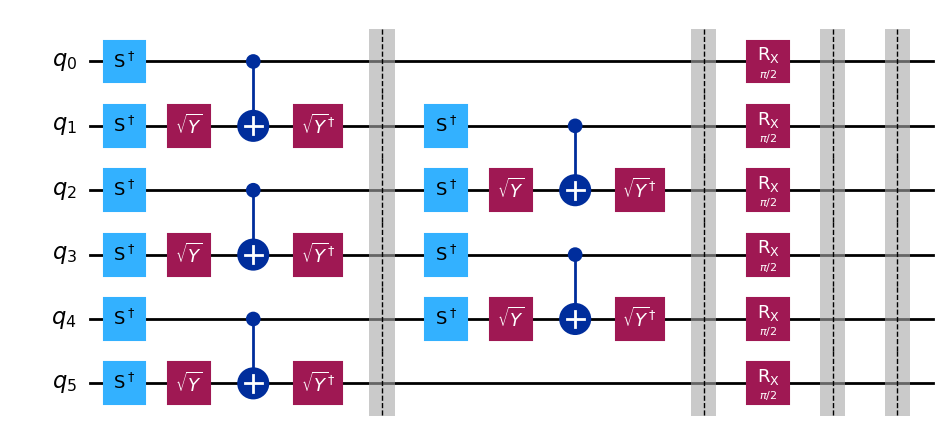

In [18]:
num_qubits = 6
num_trotter_steps = 1
rx_angle = 0.5 * np.pi

qc = generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, layer_barriers=True, trotter_barriers=True)
qc.draw(output="mpl", fold=-1)


# Demo sampler


In [19]:
def append_mirrored_1d_tfim_circuit(qc, num_trotter_steps, rx_angle, trotter_barriers=False, layer_barriers=False):
    for trotter_step in range(num_trotter_steps):
        add_mirrored_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers)
        if trotter_barriers:
            qc.barrier()


def add_mirrored_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers=False):

    qc.rx(-rx_angle, list(range(qc.num_qubits)))
    if layer_barriers:
        qc.barrier()

    #adding Rzz gates in odd layers 
    for i in range(1, qc.num_qubits - 1, 2):

        qc.append(SYGate, [i+1])
        qc.cx(i,i+1)
        qc.append(SYdgGate, [i+1])
        qc.s([i, i+1])
    if layer_barriers:
        qc.barrier()

    #adding Rzz gates in even layers 
    for i in range(0, qc.num_qubits - 1, 2):

        qc.append(SYGate, [i+1])
        qc.cx(i,i+1)
        qc.append(SYdgGate, [i+1])
        qc.s([i, i+1])
    if layer_barriers:
        qc.barrier()
    

    

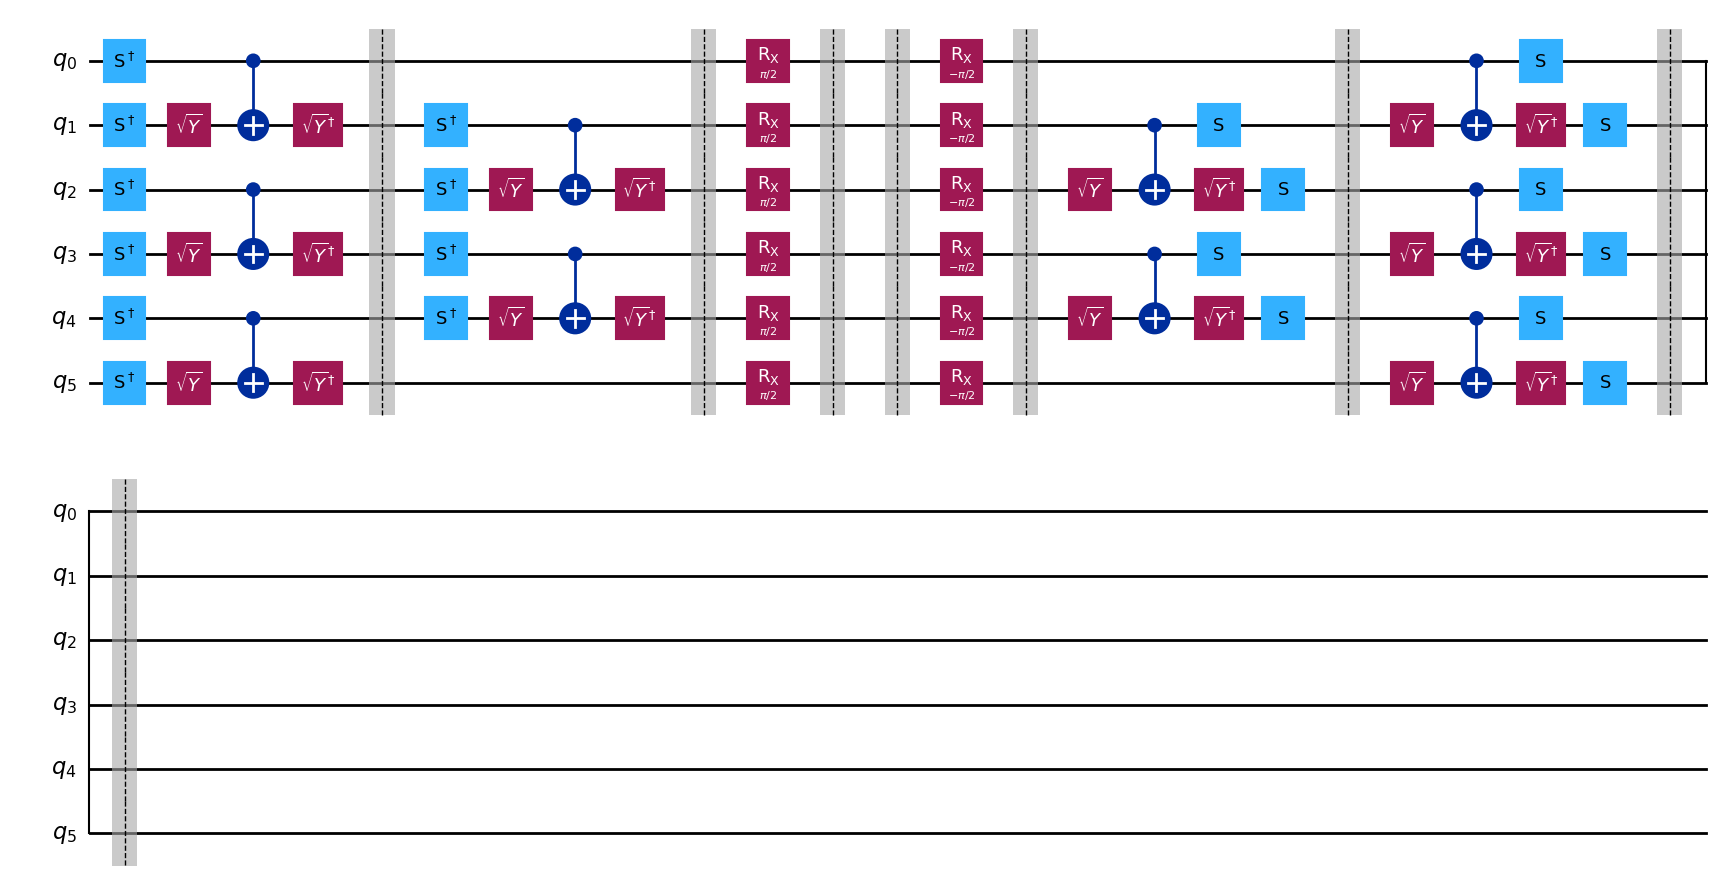

In [20]:
append_mirrored_1d_tfim_circuit(qc, num_trotter_steps, rx_angle, trotter_barriers=True, layer_barriers=True)
qc.draw(output="mpl")

# Step 1: map the problem to circuit and observables 

In [38]:
max_trotter_steps = 10
num_qubits = 100
measured_qubits = [49, 50]

qc_list = []
for trotter_steps in range(max_trotter_steps):
    qc = generate_1d_tfim_circuit(num_qubits, trotter_steps, rx_angle, num_cl_bits=len(measured_qubits), layer_barriers=True, trotter_barriers=True)
    append_mirrored_1d_tfim_circuit(qc, trotter_steps, rx_angle, trotter_barriers=True, layer_barriers=True)
    qc.measure(measured_qubits, list(range(len(measured_qubits))))
    qc_list.append(qc)

# Step 2: Optimize

In [39]:
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService

backend = "ibm_brisbane"
service = QiskitRuntimeService()
backend = service.get_backend(backend)
print("Done getting backend")

qc_transpile_list = transpile(qc_list, backend=backend, optimization_level=1)

/tmp/ipykernel_16028/1236369076.py:6: DeprecationWarning: The get_backend() method is deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use backend() instead.
  backend = service.get_backend(backend)


Done getting backend


# Step 3: Execute on hardware

In [40]:
from qiskit_ibm_runtime import SamplerV2 as Sampler


sampler = Sampler(backend=backend)
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"

job = sampler.run(qc_transpile_list)
print(job.job_id())

/tmp/ipykernel_16028/3763800939.py:4: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  sampler = Sampler(backend=backend)


ctbxqyzzw920008m366g


In [45]:
job_id = "ctbx5e5akxxg008m5j70"
job = service.job(job_id)

survival_probability_list = []

for trotter_step in range(max_trotter_steps):
    try:
        data = job.result()[trotter_step].data
        survival_probability_list.append(data.c.get_counts()['0' * len(measured_qubits)] / data.c.num_shots)
    except:
        survival_probability_list.append(0)


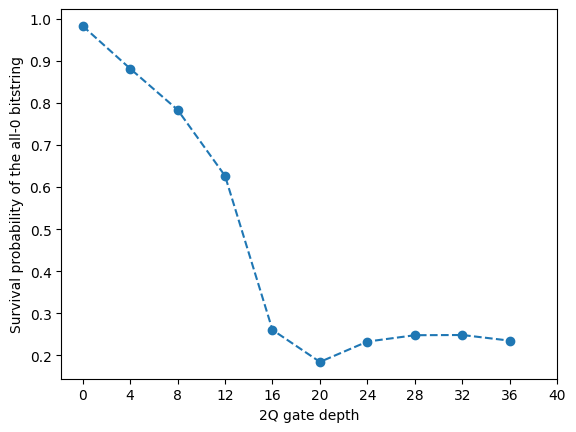

In [46]:
import matplotlib.pyplot as plt

plt.plot(list(range(0, 4 * max_trotter_steps, 4)), survival_probability_list, '--o')
plt.xlabel("2Q gate depth")
plt.ylabel("Survival probability of the all-0 bitstring")
plt.xticks(np.arange(0, 44, 4))
plt.show()

# Estimator

# Step 1: Mapping the problem

In [47]:
from qiskit.circuit import Parameter

rx_angle = Parameter("rx_angle")
trotter_steps=2
qc = generate_1d_tfim_circuit(num_qubits, trotter_steps, rx_angle)

from qiskit.quantum_info import SparsePauliOp

middle_index = num_qubits // 2
observable = SparsePauliOp("I" * middle_index + "Z" + "I" * (middle_index-1))

# Step 2: Optimize the circuit

In [49]:
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService

backend_name = "ibm_brisbane"
service = QiskitRuntimeService()
backend = service.get_backend(backend_name)

qc_tranpiled = transpile(qc, backend=backend, optimization_level=1)
observable = observable.apply_layout(qc_tranpiled.layout)

/tmp/ipykernel_16028/4133806796.py:6: DeprecationWarning: The get_backend() method is deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use backend() instead.
  backend = service.get_backend(backend_name)


# Step 3: Execute on hardware

In [51]:
from qiskit_ibm_runtime  import EstimatorV2, EstimatorOptions

min_rx_angle = 0 
max_rx_angle = np.pi/2
num_rx_angle = 12 
rx_angle_list = np.linspace(min_rx_angle, max_rx_angle, num_rx_angle)

options = EstimatorOptions()
options.resilience_level = 1
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XY4"

estimator = EstimatorV2(backend, options=options)

job = estimator.run([(qc_tranpiled, observable, rx_angle_list)])

print(job.job_id)


<bound method BasePrimitiveJob.job_id of <RuntimeJobV2('ctby468xgmhg008j58mg', 'estimator')>>


# Step 4: Post processing and plotting